Importer les Bibliothèques Nécessaires

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder ,StandardScaler , LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import os
import math

Lire le jeu de données et supprimer les colonnes Id, Alley et Fence, car Id n'est pas nécessaire et Alley ainsi que Fence contiennent beaucoup de valeurs manquantes et ne sont pas utiles dans le dataset, car elles n'influencent pas beaucoup le prix


In [2]:
train = pd.read_csv("..//Housing-prices-competition//home-data-for-ml-course/train.csv")
test = pd.read_csv("..//Housing-prices-competition//home-data-for-ml-course/test.csv")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

train.columns = train.columns.astype(str).str.strip()

test.columns = test.columns.astype(str).str.strip()
y_SalePrice = train['SalePrice']

train.drop("Id", axis = 1, inplace = True)
train.drop("SalePrice", axis = 1, inplace = True)

test.drop("Id", axis = 1, inplace = True)

In [3]:
print("Taille de train "  , train.shape)
print("Taille de test" , test.shape)

Taille de train  (1460, 79)
Taille de test (1459, 79)


In [4]:
print("\nNombre de features de chaque type :")
print(train.dtypes.value_counts())


Nombre de features de chaque type :
object    46
int64     33
Name: count, dtype: int64


détecter les types généraux

In [5]:
categorical_features = train.select_dtypes(include=['object']).columns
numerical_features = train.select_dtypes(include=['int64', 'float64']).columns
numerical_features_test = test.select_dtypes(include=['int64', 'float64']).columns

print("Catégorielles :", categorical_features)
print("Numériques :", numerical_features)



Catégorielles : Index(['MSZoning', 'LotFrontage', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')
Numériques : Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath

  valeurs manquantes 

In [6]:
train.isnull().sum()


MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual 

Vérification des types de données et conversion

In [7]:


# Convertir les colonnes contenant des nombres sous forme de texte en int ou float

train['LotFrontage'] = pd.to_numeric(train['LotFrontage'], errors='coerce') 
train['MasVnrArea'] = pd.to_numeric(train['MasVnrArea'], errors='coerce')
train['GarageYrBlt'] = pd.to_numeric(train['GarageYrBlt'], errors='coerce')


test['LotFrontage'] = pd.to_numeric(test['LotFrontage'], errors='coerce') 
test['MasVnrArea'] = pd.to_numeric(test['MasVnrArea'], errors='coerce')
test['GarageYrBlt'] = pd.to_numeric(test['GarageYrBlt'], errors='coerce')
test["Utilities"] = test["Utilities"].replace(-1, train["Utilities"].mode()[0])


In [8]:
def cap_outliers_iqr(df):
    df = df.copy()
    for column in df.select_dtypes(include=['int64', 'float64']):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = df[column].clip(lower_bound, upper_bound)
    return df

train = cap_outliers_iqr(train)
test = cap_outliers_iqr(test)



train["TotalSF"] = train["TotalBsmtSF"] + train["1stFlrSF"] + train["2ndFlrSF"]
train["TotalPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + train["3SsnPorch"] + train["ScreenPorch"]
train["TotalBathrooms"] = train["FullBath"] + (0.5 * train["HalfBath"]) + train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"])

test["TotalSF"] = test["TotalBsmtSF"] + test["1stFlrSF"] + test["2ndFlrSF"]
test["TotalPorchSF"] = test["OpenPorchSF"] + test["EnclosedPorch"] + test["3SsnPorch"] + test["ScreenPorch"]
test["TotalBathrooms"] = test["FullBath"] + (0.5 * test["HalfBath"]) + test["BsmtFullBath"] + (0.5 * test["BsmtHalfBath"])

# Vérification des nouvelles features
print(train[["TotalSF", "TotalPorchSF", "TotalBathrooms"]].head())
print(test[["TotalSF", "TotalPorchSF", "TotalBathrooms"]].head())


   TotalSF  TotalPorchSF  TotalBathrooms
0   2566.0            61             3.5
1   2524.0             0             2.0
2   2706.0            42             3.5
3   2473.0            35             2.0
4   3343.0            84             3.5
   TotalSF  TotalPorchSF  TotalBathrooms
0   1778.0             0             1.0
1   2658.0            36             1.5
2   2557.0            34             2.5
3   2530.0            36             2.5
4   2560.0            82             2.0


détecter nouveaux  types généraux

In [9]:
Nv_Cat_Donnes = train.select_dtypes(include=['object']).columns
Nv_Num_Donnes = train.select_dtypes(include=['int64', 'float64']).columns
print("Catégorielles :", Nv_Cat_Donnes)
print("Numériques :", Nv_Num_Donnes)

Catégorielles : Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
Numériques : Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',


Pourcentage de valeurs manquantes

In [10]:
missing_percentage = (train.isnull().sum() / len(train)) * 100
missing_data = missing_percentage[missing_percentage > 0]

print(missing_data)
# Les valeur Nan sur LotFrontage , GarageYrBlt , MasVnrArea , MiscFeature


LotFrontage    17.739726
MasVnrArea      0.547945
GarageYrBlt     5.547945
dtype: float64


gérer ( missing values )

In [11]:

train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].median())
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0)
train['MasVnrArea'] = train['MasVnrArea'].fillna(0)



test['LotFrontage'] = test['LotFrontage'].fillna(test['LotFrontage'].median())
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(0)
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)

Standardisation (scaling)

In [12]:
train_numericall = train.select_dtypes(include=["int64", "float64"]).columns.drop("SalePrice", errors="ignore")
scaler = StandardScaler()
numerical_features = [col for col in train_numericall if col != "SalePrice"]
train[numerical_features] = scaler.fit_transform(train[numerical_features])


In [13]:
test_categorical = [feature for feature in test.columns if test[feature].dtype == "object"] 
test_numerical = [feature for feature in test.columns if feature not in test_categorical]
scaler = StandardScaler()
test[test_numerical] = scaler.fit_transform(test[test_numerical])

La coorelation

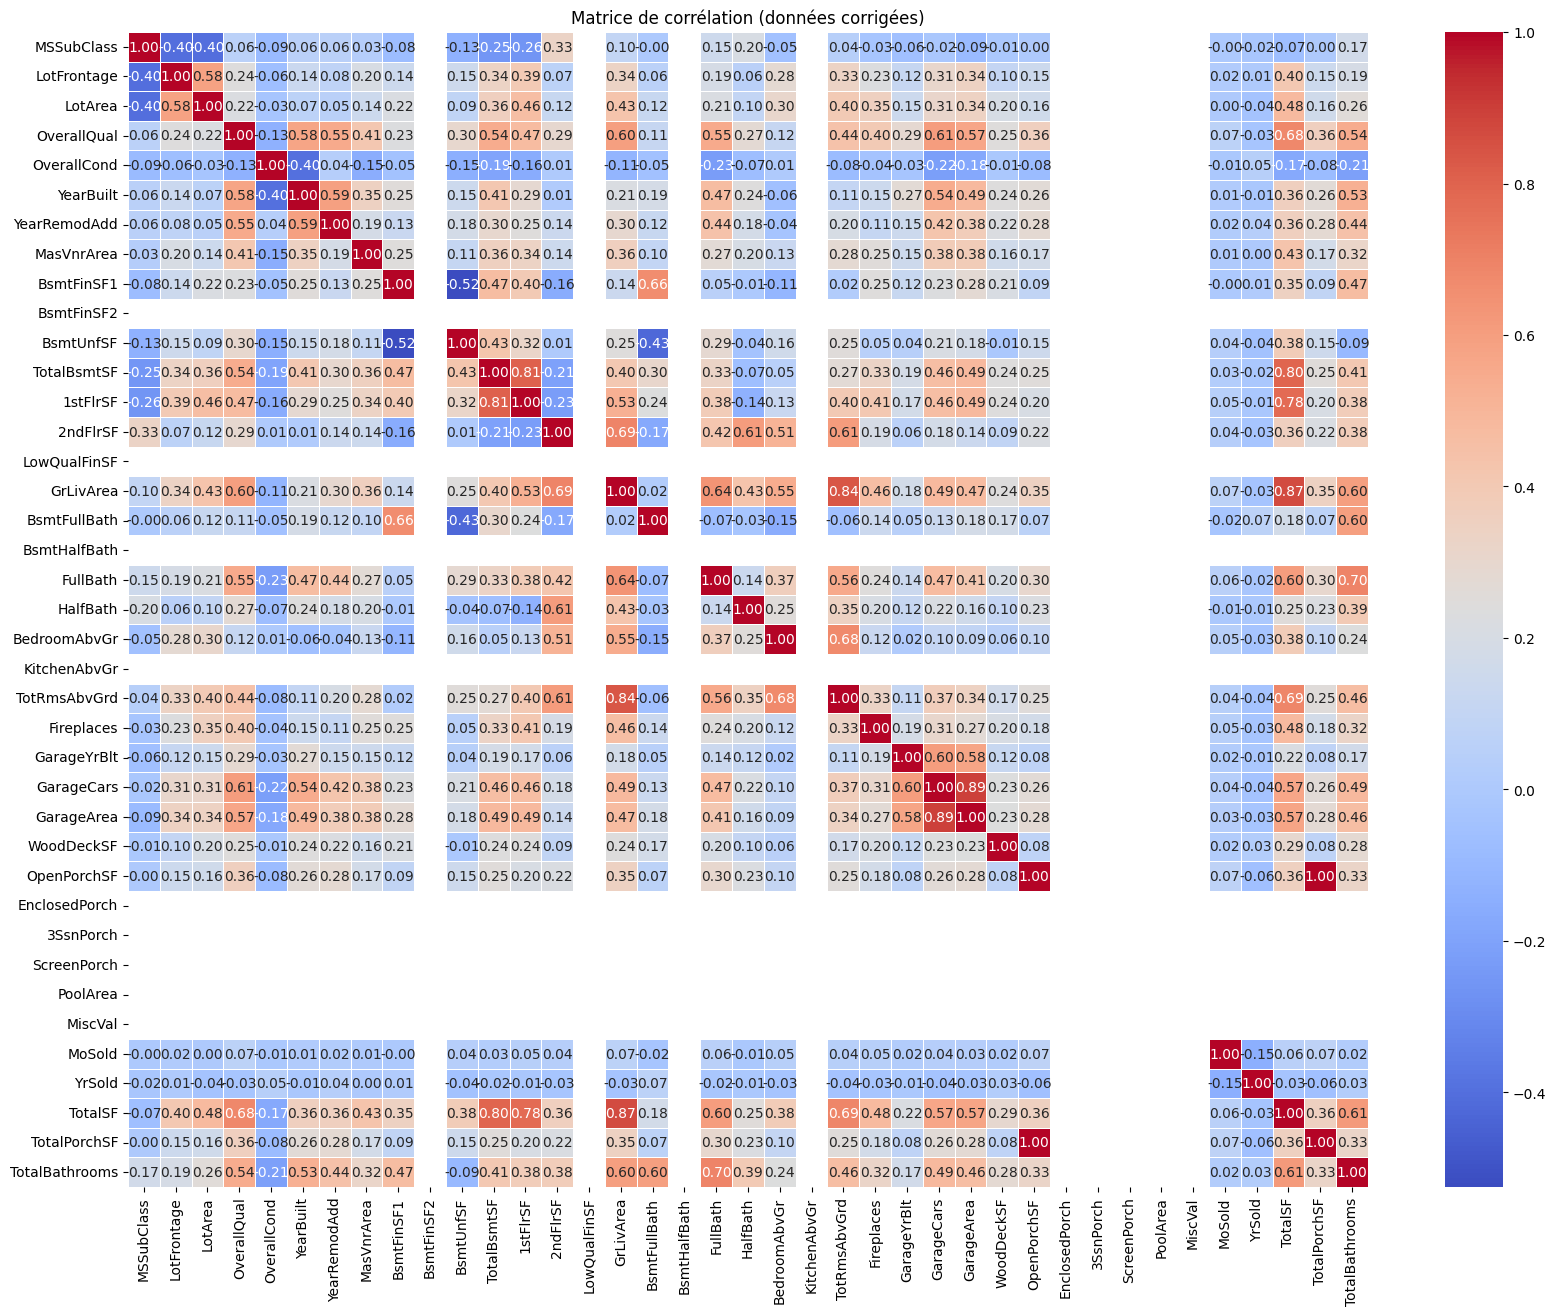

In [14]:
numeric_data = train.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de corrélation (données corrigées)')
plt.show()

ACP

In [15]:

# Sélection des features numériques
numeric_features = train.select_dtypes(include=['float64', 'int64']).columns
numeric_features_te = test.select_dtypes(include=['float64', 'int64']).columns

# Remplacement des NaN par la moyenne
train[numeric_features] = train[numeric_features].fillna(train[numeric_features].mean())
test[numeric_features_te] = test[numeric_features_te].fillna(test[numeric_features_te].mean())

# Standardisation des données
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[numeric_features])
test_scaled = scaler.transform(test[numeric_features_te]) 

# Application du PCA
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_scaled)
test_pca = pca.transform(test_scaled)  # Plus d'erreur ici 🎯

# 🔥 Convertir en DataFrame avec de nouveaux noms de colonnes
num_components = train_pca.shape[1]  # Nombre de colonnes après PCA
pca_columns = [f"PCA_{i}" for i in range(num_components)]

train_pca_df = pd.DataFrame(train_pca, columns=pca_columns)
test_pca_df = pd.DataFrame(test_pca, columns=pca_columns)

# 🔄 Mise à jour des datasets
train = train.drop(columns=numeric_features).reset_index(drop=True)  # Supprimer les anciennes features
test = test.drop(columns=numeric_features_te).reset_index(drop=True)

train = pd.concat([train, train_pca_df], axis=1)  # Ajouter PCA features
test = pd.concat([test, test_pca_df], axis=1)

print("✅ PCA appliqué avec succès !")


✅ PCA appliqué avec succès !


Extraction des couples de variables ayant une corrélation supérieure à 0.8

In [16]:
corr_threshold = 0.8
corr_pairs = {}

for col in correlation_matrix.columns:
    corr_pairs[col] = []
    corr_values = correlation_matrix[abs(correlation_matrix[col]) > corr_threshold][col].index.tolist()
    for pair in corr_values:
        if pair != col:
            corr_pairs[col].append(pair)

# Affichage des couples de variables ayant une corrélation supérieure à 0.8
print("Couples de variables ayant une corrélation supérieure à 0.8 :\n")
for col, pairs in corr_pairs.items():
    if len(pairs) > 0:
        for pair in pairs:
            print(col, "-", pair)

Couples de variables ayant une corrélation supérieure à 0.8 :

TotalBsmtSF - 1stFlrSF
1stFlrSF - TotalBsmtSF
GrLivArea - TotRmsAbvGrd
GrLivArea - TotalSF
TotRmsAbvGrd - GrLivArea
GarageCars - GarageArea
GarageArea - GarageCars
OpenPorchSF - TotalPorchSF
TotalSF - GrLivArea
TotalPorchSF - OpenPorchSF


  dropping features

In [17]:
# Liste des colonnes à supprimer
columns_to_drop = ["GarageArea", "1stFlrSF", "TotRmsAbvGrd"]

# Vérifier si les colonnes existent avant de les supprimer
train = train.drop(columns=[col for col in columns_to_drop if col in train.columns])
test = test.drop(columns=[col for col in columns_to_drop if col in test.columns])

print("✅ Colonnes supprimées avec succès !")


✅ Colonnes supprimées avec succès !


mutual info

In [18]:
# Sélection des features numériques
y = y_SalePrice
train_numerical = train.select_dtypes(include=["int64", "float64"]).columns.drop("SalePrice", errors="ignore")
mutual_df = train[train_numerical]

# Calcul de l'information mutuelle pour les features numériques
mutual_infoN = mutual_info_regression(mutual_df.fillna(0), y, random_state=1)

mutual_infoN = pd.Series(mutual_infoN)
mutual_infoN.index = mutual_df.columns

# Affichage des résultats
pd.DataFrame(mutual_infoN.sort_values(ascending=False), columns=["Mutual Information"]).style.background_gradient("coolwarm", axis=0)

# Vérifier quelles colonnes catégorielles existent réellement
valid_categorical_features = [col for col in categorical_features if col in train.columns]

# Sélectionner uniquement les colonnes existantes
mutual_df_categorical = train[valid_categorical_features]

# Encodage des features catégorielles
for colname in mutual_df_categorical:
    mutual_df_categorical.loc[:, colname], _ = mutual_df_categorical[colname].factorize()

# Calcul de l'information mutuelle pour les features catégorielles
mutual_infoC = mutual_info_regression(mutual_df_categorical.fillna("Do_not_have_feature"), y, random_state=1)

mutual_infoC = pd.Series(mutual_infoC)
mutual_infoC.index = mutual_df_categorical.columns

# Affichage des résultats
pd.DataFrame(mutual_infoC.sort_values(ascending=False), columns=["Categorical_Feature_MI"]).style.background_gradient("cool")

# Suppression des features numériques ayant une information mutuelle faible (seuil des 10% les plus faibles)
mi_thresholdN = mutual_infoN.quantile(0.1)  # Seuil: 10% des features les moins importantes
low_mi_features = mutual_infoN[mutual_infoN < mi_thresholdN].index.tolist()

train.drop(columns=low_mi_features, inplace=True)
test.drop(columns=low_mi_features, inplace=True)


/var/folders/rg/r64x99yx2k91vgyysnwnb7pc0000gn/T/ipykernel_81765/509816195.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mutual_infoC = mutual_info_regression(mutual_df_categorical.fillna("Do_not_have_feature"), y, random_state=1)


In [19]:
train.fillna("NA", inplace=True)
test.fillna("NA", inplace=True)

 Encoding des Features Ordinales et nominals

In [20]:


train_ordinal = [ 'LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                    'BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual',
                    'GarageCond','PavedDrive','PoolQC','Fence']

train_nominal = ["MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", 
                    "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating",
                    "CentralAir", 'Electrical',"GarageType", "MiscFeature", "SaleType", "SaleCondition"]

test_ordinal = train_ordinal
test_nominal = train_nominal

ordinal_mappings = {
    "LotShape": ["IR3", "IR2", "IR1", "Reg"],
    "Utilities": ["ELO", "NoSeWa", "NoSewr", "AllPub"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "ExterQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "ExterCond": ["Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtQual": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtCond": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "BsmtExposure": ["NA", "No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "HeatingQC": ["Po", "Fa", "TA", "Gd", "Ex"],
    "KitchenQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "Functional": ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
    "FireplaceQu": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "GarageFinish": ["NA", "Unf", "RFn", "Fin"],
    "GarageQual": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "GarageCond": ["NA", "Po", "Fa", "TA", "Gd", "Ex"],
    "PavedDrive": ["N", "P", "Y"],
    "PoolQC": ["NA", "Fa", "TA", "Gd", "Ex"],
    "Fence": ["NA", "MnWw", "GdWo", "MnPrv", "GdPrv"]
}

# -------------------
# Encodage Ordinal (train & test)
# -------------------

# Supprimer les espaces et remplir les valeurs manquantes avec "NA" (ou autre valeur neutre)
for col in train_ordinal:
    train[col] = train[col].astype(str).str.strip().fillna("NA")
    test[col] = test[col].astype(str).str.strip().fillna("NA")

# Initialiser et appliquer OrdinalEncoder avec gestion des valeurs inconnues
ordinal_encoder = OrdinalEncoder(categories=[ordinal_mappings[col] for col in train_ordinal], 
                                 handle_unknown="use_encoded_value", 
                                 unknown_value=-1)

train[train_ordinal] = ordinal_encoder.fit_transform(train[train_ordinal])
test[test_ordinal] = ordinal_encoder.transform(test[test_ordinal])  # Pas de fit sur test !

# -------------------
# Encodage Nominal (Label Encoding) AVEC GESTION DES VALEURS INCONNUES
# -------------------
# --------------------------------
label_encoders = {}

for col in train_nominal:
   train[col] = train[col].astype(str).fillna("Unknown")  # Gérer les NaN
   test[col] = test[col].astype(str).fillna("Unknown")  # Même traitement pour le test
    
   le = LabelEncoder()
   train[col] = le.fit_transform(train[col])  # On fit sur train

    # Gérer les valeurs inconnues en test
   test[col] = test[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

   label_encoders[col] = le  # Sauvegarde des encoders

# --------------------------------
# train = pd.get_dummies(train, columns=train_nominal, dtype=int)
# test = pd.get_dummies(test, columns=train_nominal, dtype=int)

# # Aligner les colonnes de test sur train (ajouter les colonnes manquantes avec 0)
# missing_cols = set(train.columns) - set(test.columns)
# for col in missing_cols:
#     test[col] = 0  # Ajouter les colonnes manquantes

# # S'assurer que l'ordre des colonnes est le même
# test = test[train.columns]

train = pd.concat([train, y_SalePrice], axis=1)


In [21]:
print(train.shape

,test.shape)

(1460, 61) (1459, 60)


final Data

In [22]:
train.to_csv('final_data.csv', index=False)

test.to_csv('final_test_data.csv', index=False)
